In [1]:
import pandas as pd
from processor.processor import Processor as p
from modeler.modeler import Modeler as m
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
pdr_crypto = pd.read_csv("./csv_files/prices/PDR_CRYPTO")
yahoo_crypto = pd.read_csv("./csv_files/prices/BTC-USD.csv")

In [3]:
pdr_crypto = p.column_date_processing(pdr_crypto).groupby("date").mean().reset_index()
yahoo_crypto = p.column_date_processing(pdr_crypto).groupby("date").mean().reset_index()

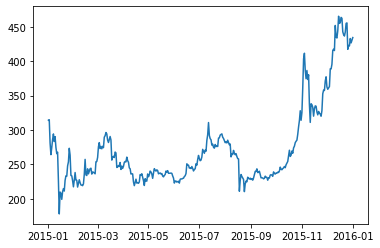

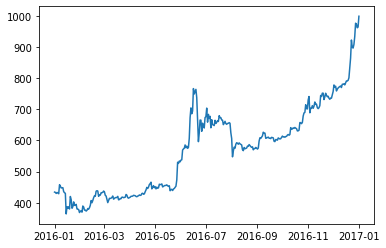

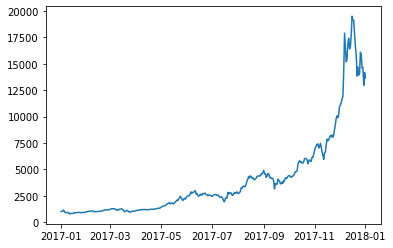

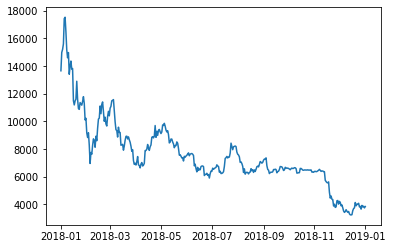

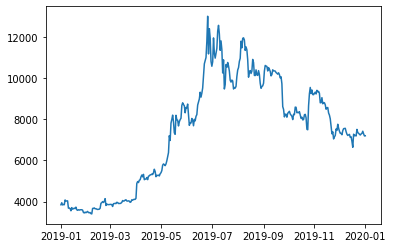

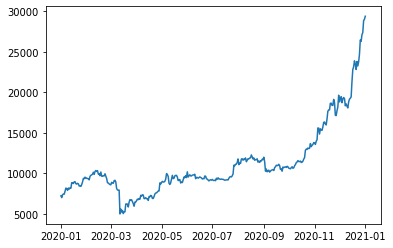

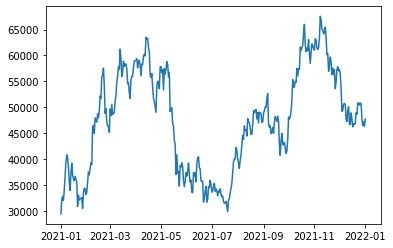

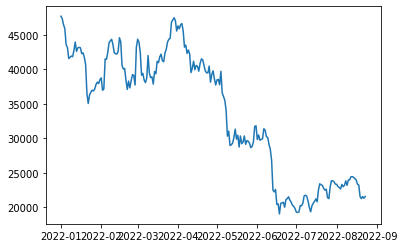

In [4]:
for year in range(2015,2023):
    start_date = datetime(year,1,1)
    end_date = datetime(year+1,1,1)
    viz = pdr_crypto[(pdr_crypto["date"]>=start_date) & (pdr_crypto["date"]<=end_date)]
    plt.plot(viz["date"],viz["adjclose"])
    plt.show()

In [5]:
merged = pdr_crypto[["date","adjclose"]].merge(yahoo_crypto[["date","adjclose"]].rename(columns={"adjclose":"yahoo_adjclose"}),on="date")

In [6]:
merged["diff"] =( merged["yahoo_adjclose"] - merged["adjclose"]) / merged["adjclose"]
merged["diff"] = [abs(x) for x in merged["diff"]]

In [7]:
strategies = ["rolling","window"]
rollings = [7,14,30,90,100]
signals = [0.05,0.1,0.15]
reqs = [0.05,0.1,0.15]
# due_dates = [7,14]
# holds = [True]
values = [True,False]

In [8]:
parameters = []
for strategy in strategies:
    for rolling in rollings:
        for signal in signals:
            for req in reqs:
                for value in values:
                    parameters.append({"strategy":strategy,
                                      "rolling":rolling,
                                      "signal":signal,
                                      "req":req,
                                      "value":value})

In [9]:
print(len(parameters))

180


In [10]:
for rolling in rollings:
    yahoo_crypto[f"rolling_{rolling}"] = yahoo_crypto["adjclose"].rolling(window=rolling).mean()
    yahoo_crypto[f"window_{rolling}"] = (yahoo_crypto["adjclose"] - yahoo_crypto["adjclose"].shift(rolling)) / yahoo_crypto["adjclose"].shift(rolling)

In [11]:
sim = yahoo_crypto.dropna()

In [12]:
parameters[0]

{'strategy': 'rolling',
 'rolling': 7,
 'signal': 0.05,
 'req': 0.05,
 'value': True}

In [13]:

f"{strategy}_{rolling}"

'window_100'

In [14]:
start = datetime(2016,1,1)
end = datetime(2022,1,1)
trades = []
for parameter in tqdm(parameters):
    iterration_sim = sim.copy()
    strategy = parameter["strategy"]
    rolling = parameter["rolling"]
    iterration_sim["delta"] = (iterration_sim["adjclose"] - iterration_sim[f"{strategy}_{rolling}"]) / iterration_sim[f"{strategy}_{rolling}"]
    if parameter["value"] == False:
        iterration_sim["delta"] = iterration_sim["delta"] * -1
    date = start
    while date < end:
        current = iterration_sim[iterration_sim["date"]==date]
        if current.index.size < 1:
            date = date + timedelta(days=1)
        else:
            if current["delta"].item() >= parameter["signal"]:
                trade = current[["date","adjclose"]].to_dict("records")[0]
                exits = iterration_sim[iterration_sim["date"]>date]
                exits["gain"] = (exits["adjclose"] - trade["adjclose"]) / trade["adjclose"]
                profits = exits[exits["gain"]>=parameter["req"]]
                if profits.index.size < 1:
                    exit = exits.iloc[-1]
                    trade["sell_price"] = exit["adjclose"]
                else:
                    exit = profits.iloc[0]
                    trade["sell_price"] = trade["adjclose"] * (1+parameter["req"])
                trade["sell_date"] = exit["date"]
                for key in parameter.keys():
                    trade[key] = parameter[key]
                trade["delta"] = (trade["sell_price"] - trade["adjclose"]) / trade["adjclose"]
                trades.append(trade)
                date = exit["date"] + timedelta(days=1)
            else:
                date = date + timedelta(days=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:29<00:00,  6.03it/s]


In [15]:
t = pd.DataFrame(trades)

In [16]:
100 * (1+0.05) * (1-0.1)

94.5

In [27]:
analysis = []
fee_rate = 0.0
seed_funding = 100
for parameter in parameters:
    iteration = t.copy()
    for key in parameter.keys():
        iteration = iteration[iteration[key]==parameter[key]]
    if iteration.index.size > 0:
        iteration.sort_values("date",inplace=True)
        initial = seed_funding
        fee = 0
        for delta in iteration["delta"]:
            cash_inflow = initial * (delta)
            if delta > 0:
                trade_fee = cash_inflow * fee_rate
                new_cash_inflow = cash_inflow - trade_fee
                initial += new_cash_inflow
                fee += trade_fee
            else:
                initial += cash_inflow
        new_dictionary = {}
        for key in parameter.keys():
            new_dictionary[key] = parameter[key]
        new_dictionary["pv"] = initial
        new_dictionary["fee"] = fee
        analysis.append(new_dictionary)

In [28]:
a = pd.DataFrame(analysis)
a.sort_values("pv",ascending=False).head(20)

,strategy,rolling,signal,req,value,pv,fee
50,rolling,30,0.15,0.10,True,3091.268053,0.0
28,rolling,14,0.10,0.15,True,2489.145756,0.0
26,rolling,14,0.10,0.10,True,1919.434250,0.0
34,rolling,14,0.15,0.15,True,1423.177165,0.0
10,rolling,7,0.10,0.15,True,1423.177165,0.0
22,rolling,14,0.05,0.15,True,1207.348908,0.0
40,rolling,30,0.05,0.15,True,1140.268387,0.0
46,rolling,30,0.10,0.15,True,1140.268387,0.0
130,window,30,0.05,0.15,True,1140.268387,0.0
154,window,90,0.10,0.15,True,1140.268387,0.0


In [19]:
best_it = a.sort_values("pv",ascending=False).iloc[0]
best_trades = t.copy()
for key in parameter.keys():
    best_trades = best_trades[(best_trades[key]==best_it[key])]
best_trades.sort_values("date",inplace=True)
pvs = []
initial = seed_funding
for delta in best_trades["delta"]:
    initial = initial * (1+delta)
    pvs.append(initial)

In [20]:
best_trades["pv"] = pvs

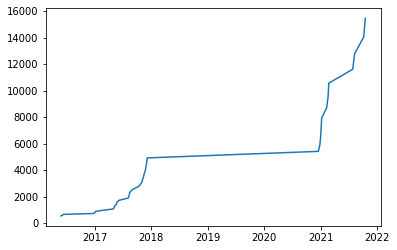

In [21]:
plt.plot(best_trades["date"],best_trades["pv"])

In [22]:
best_trades.sort_values("delta",ascending=False).head(20)

,date,adjclose,sell_price,sell_date,strategy,rolling,signal,req,value,delta,pv
1229,2017-08-12,3884.709961,4273.180957,2017-08-14,rolling,30,0.15,0.1,True,0.1,2088.624085
1235,2017-11-17,7708.990234,8479.889258,2017-11-25,rolling,30,0.15,0.1,True,0.1,3700.124972
1220,2017-01-05,1013.380005,1114.718005,2017-02-21,rolling,30,0.15,0.1,True,0.1,885.780500
1238,2017-12-07,17899.699219,19689.669141,2020-12-16,rolling,30,0.15,0.1,True,0.1,4924.866338
1237,2017-12-02,11074.599609,12182.059570,2017-12-06,rolling,30,0.15,0.1,True,0.1,4477.151216
1231,2017-09-01,4892.009766,5381.210742,2017-10-12,rolling,30,0.15,0.1,True,0.1,2527.235142
1240,2020-12-27,26272.294922,28899.524414,2020-12-31,rolling,30,0.15,0.1,True,0.1,5959.088269
1217,2016-06-13,704.375977,774.813574,2016-12-02,rolling,30,0.15,0.1,True,0.1,665.500000
1219,2017-01-03,1043.839966,1148.223962,2017-01-04,rolling,30,0.15,0.1,True,0.1,805.255000
1232,2017-10-13,5647.209961,6211.930957,2017-10-31,rolling,30,0.15,0.1,True,0.1,2779.958657
